[ 29900  30750  32450 ... 128500 134000 132000]
[ 29900  30750  32450 ... 128500 134000 132000]
[[ 29900]
 [ 30750]
 [ 32450]
 ...
 [128500]
 [134000]
 [132000]]
2305 257


C:\Program Files\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Epoch 1/100
 - 17s - loss: 0.0334
Epoch 2/100
 - 14s - loss: 3.8996e-04
Epoch 3/100
 - 15s - loss: 3.4400e-04
Epoch 4/100
 - 13s - loss: 3.3957e-04
Epoch 5/100
 - 13s - loss: 3.3238e-04
Epoch 6/100
 - 13s - loss: 3.3056e-04
Epoch 7/100
 - 14s - loss: 3.4528e-04
Epoch 8/100
 - 15s - loss: 3.3000e-04
Epoch 9/100
 - 16s - loss: 3.3896e-04
Epoch 10/100
 - 14s - loss: 3.3395e-04
Epoch 11/100
 - 13s - loss: 3.3213e-04
Epoch 12/100
 - 14s - loss: 3.2309e-04
Epoch 13/100
 - 12s - loss: 3.2783e-04
Epoch 14/100
 - 12s - loss: 3.2680e-04
Epoch 15/100
 - 14s - loss: 3.3184e-04
Epoch 16/100
 - 13s - loss: 3.2384e-04
Epoch 17/100
 - 14s - loss: 3.2747e-04
Epoch 18/100
 - 13s - loss: 3.2592e-04
Epoch 19/100
 - 13s - loss: 3.2064e-04
Epoch 20/100
 - 14s - loss: 3.1734e-04
Epoch 21/100
 - 14s - loss: 3.1938e-04
Epoch 22/100
 - 13s - loss: 3.2162e-04
Epoch 23/100
 - 14s - loss: 3.1938e-04
Epoch 24/100
 - 13s - loss: 3.1988e-04
Epoch 25/100
 - 12s - loss: 3.1997e-04
Epoch 26/100
 - 13s - loss: 3.1293e-04

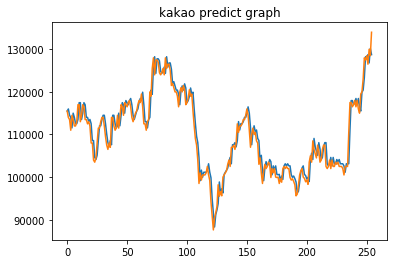

In [2]:
#
# LSTM모델을 이용해서 주가예측
#
import os
import settings
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error
import pymysql


# 데이터셋 생성 함수
look_back = 1
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)
 
# 저장되어있는 주식데이터 불러오기
sydtpath = os.path.join(settings.BASE_DIR, 'chart_data/%s' % (settings.get_today_str()))
stock_code = "kakao"
fullpath = sydtpath + os.path.sep + stock_code + '.csv'
pandf = pd.read_csv(fullpath, index_col="Date")

# 데이터 전처리
nparr = pandf['Close'].values[1:]     # 맨처음 'Close'데이터부터 차례대로 nparr에 저장
print(nparr)
nparr.astype('float32')    # float형으로 변환
print(nparr)
nparr = nparr.reshape(-1,1)
print(nparr)
 
# 정규화 (0~1사이의 값으로 바꿔준다)
scaler = MinMaxScaler(feature_range=(0, 1))
nptf = scaler.fit_transform(nparr)
 
# 학습용, 테스트용 데이터로 나누기 (90%를 학습용 데이터, 10%를 테스트용 데이터)
train_size = int(len(nptf) * 0.9)
test_size = len(nptf) - train_size
train, test = nptf[0:train_size], nptf[train_size:len(nptf)]
print(len(train), len(test))
 
# 학습을 위한 데이터셋 생성하기
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
 
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
 
# LSTM모델
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
 
# 예측하기
testPredict = model.predict(testX)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Train Score: %.2f RMSE' % testScore)
 
# 예측 데이터 출력
lastX = nptf[-1]
lastX = np.reshape(lastX, (1, 1, 1))
lastY = model.predict(lastX)
predict = scaler.inverse_transform(lastY)
print('Predict the Close value of final day: %d' % predict)  # 데이터 입력 마지막 다음날 종가 예측
    
# 차트출력, 저장
plt.plot(testPredict)
plt.plot(testY)

plt.title('kakao predict graph')

plt.savefig("./chart_picture/kakao.png",dpi=300)
plt.show()

# 사진 데이터 binary형식으로 바꿔주는 함수
def convertToBinaryData(filename):
    #Convert digital data to binary format
    with open(filename, 'rb') as file:
        binaryData = file.read()
    return binaryData


# 
# DB테이블 값 삽입 (INSERT)
#
# MySQL Connection 연결
connection = pymysql.connect(host='222.122.86.187', port=3306, user='geniuses777', password='stock7840',
                       db='geniuses777', charset='utf8')
try:
    with connection.cursor() as cursor:
        sql = 'INSERT INTO stock_hye (company_name, stock_price, image) VALUES (%s, %s, %s) ON DUPLICATE KEY UPDATE stock_price = VALUES(stock_price), image = VALUES(image)'
        image = convertToBinaryData("C:\source\SPF\chart_picture\kakao.png")
        cursor.execute(sql, ('kakao', int(predict), image))          # 넣으려는 값
    connection.commit()
    
finally:
    connection.close()